Final Project
---



Andres Coronado
Riccardo Caprile
Giacomo Garbarino



In this project we present a python notebook which uses spark to represent (big) data in Graphs using Graph Frames Library.

# 0.1 Preparing the environment
---

We will need to use the graph frames library. 

- to do so in the pyspark machine we need to have `graphframes-0.8.1-spark3.0-s_2.12.jar`
- since Maven spark repository (bintray) is down we cannot use maven to add the dependency to spark and we need to do it manually
- in the docker-compose of this lab we need to `dowload` the file or copy that file using `docker cp` or `wget`
- After that we need to specify to our jupyter environment to use graphframes jar file when execuing `pyspark-shell`

In [6]:
# using graphframes jar file in pySpark shell

import os
import sys
import urllib.request as ur

# downloading graphframes
ur.urlretrieve("https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar", "/opt/workspace/jars/graphframes-0.8.1-spark3.0-s_2.12.jar")

# installing packages 
!{sys.executable} -m pip install pandas >> /opt/workspace/log.txt
!{sys.executable} -m pip install graphframes >> /opt/workspace/log.txt
!{sys.executable} -m pip install matplotlib >> /opt/workspace/log.txt

print ("All dependencies should be installed. check /opt/workspace/log.txt")

# setting graphframes jar as dependency in spark shell
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /opt/workspace/jars/graphframes-0.8.1-spark3.0-s_2.12.jar pyspark-shell'

All dependencies should be installed. check log.txt


# 0.2 Preparing the pySpark sql context
---

In [9]:
from pyspark.sql import SparkSession

# load spark sql context using session

executor = { 
  "memory": "1024m",
}

spark = SparkSession.\
        builder.\
        appName("lsc-final-project").\
        master("spark://spark-master:7077").config("spark.executor.memory", executor["memory"]).getOrCreate()

# 0.3 Preparing the data

We took a 2 Gigabytes dataset from kaggle : https://www.kaggle.com/benhamner/sf-bay-area-bike-share/
and store it in our simulated Hadoop File system environment in order to use spark and spark workers:

after download the archive, just copy the csv files in the shared docker volume `/opt/workspace/data`

```bash
docker cp ./*.csv jupyterlab:/opt/workspace/data`
```

we will have this files available in our notebook:
---
- *stations* csv file `data/station.csv`
- *status* csv file `data/status.csv`
- *trip* csv file `data/trip.csv`
- *wather* csv file `data/weather.csv`


In [10]:
# load csv files: complete here using spark.read.csv()

station = spark.read.csv(path="data/station.csv", sep=",", header=True)
#status = spark.read.csv(path="data/status.csv", sep=",", header=True)
trip = spark.read.csv(path="data/trip.csv", sep=",", header=True)
#wather = spark.read.csv(path="data/weather.csv", sep=",", header=True)

It is always reasonable to print out the schema in the data tables we are intrested in using `printSchema()`:

In [11]:
# print the schema:

print("station dataset")
# complete here
station.printSchema()
print("trip dataset")
#complete here
trip.printSchema()

station dataset
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- dock_count: string (nullable = true)
 |-- city: string (nullable = true)
 |-- installation_date: string (nullable = true)

trip dataset
root
 |-- id: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- start_date: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- subscription_type: string (nullable = true)
 |-- zip_code: string (nullable = true)



# 2. Preparing the Graph using GraphFrames
---

Now we can build a graph, using stations as **Vertices** and trips as **Edges** 
(We're also going to cache the input DataFrames.)

- **Vertices** : the distinct stations (vertices), *Tip* drop the `id` the colum and rename `name` with `id`
- **Edges** : the trips (oriented edges) renaming colums `start_station_name` with src and `end_station_name` dst

In [12]:
# complete here, we have to use the station names as id to get the graph
stationVertices = station.distinct().withColumnRenamed("id", "station_id").withColumnRenamed("name", "id")
tripEdges = trip.withColumnRenamed("start_station_name", "src").withColumnRenamed("end_station_name", "dst")

In [13]:
stationVertices.show(n=5)

+----------+--------------------+------------------+-------------------+----------+-------------+-----------------+
|station_id|                  id|               lat|               long|dock_count|         city|installation_date|
+----------+--------------------+------------------+-------------------+----------+-------------+-----------------+
|        67|      Market at 10th|37.776619000000004|-122.41738500000001|        27|San Francisco|        8/23/2013|
|        10|  San Jose City Hall|         37.337391|        -121.886995|        15|     San Jose|         8/6/2013|
|        11|         MLK Library|         37.335885|-121.88566000000002|        19|     San Jose|         8/6/2013|
|        34|Palo Alto Caltrai...|         37.443988|        -122.164759|        23|    Palo Alto|        8/14/2013|
|        42|    Davis at Jackson|          37.79728|        -122.398436|        15|San Francisco|        8/19/2013|
+----------+--------------------+------------------+-------------------+

In [14]:
tripEdges.show(n=5)

+----+--------+---------------+--------------------+----------------+---------------+--------------------+--------------+-------+-----------------+--------+
|  id|duration|     start_date|                 src|start_station_id|       end_date|                 dst|end_station_id|bike_id|subscription_type|zip_code|
+----+--------+---------------+--------------------+----------------+---------------+--------------------+--------------+-------+-----------------+--------+
|4576|      63|8/29/2013 14:13|South Van Ness at...|              66|8/29/2013 14:14|South Van Ness at...|            66|    520|       Subscriber|   94127|
|4607|      70|8/29/2013 14:42|  San Jose City Hall|              10|8/29/2013 14:43|  San Jose City Hall|            10|    661|       Subscriber|   95138|
|4130|      71|8/29/2013 10:16|Mountain View Cit...|              27|8/29/2013 10:17|Mountain View Cit...|            27|     48|       Subscriber|   97214|
|4251|      77|8/29/2013 11:29|  San Jose City Hall|      

## 2.1 Build the graph
---

using the `GraphFrame(Vertices, Edges)` constructor we can build a graph

In [15]:
from graphframes import *


# complete here ...
stationGraph = GraphFrame(stationVertices, tripEdges)


In [16]:
stationGraph.vertices.show()
stationGraph.edges.show()

+----------+--------------------+------------------+-------------------+----------+-------------+-----------------+
|station_id|                  id|               lat|               long|dock_count|         city|installation_date|
+----------+--------------------+------------------+-------------------+----------+-------------+-----------------+
|        67|      Market at 10th|37.776619000000004|-122.41738500000001|        27|San Francisco|        8/23/2013|
|        10|  San Jose City Hall|         37.337391|        -121.886995|        15|     San Jose|         8/6/2013|
|        11|         MLK Library|         37.335885|-121.88566000000002|        19|     San Jose|         8/6/2013|
|        34|Palo Alto Caltrai...|         37.443988|        -122.164759|        23|    Palo Alto|        8/14/2013|
|        42|    Davis at Jackson|          37.79728|        -122.398436|        15|San Francisco|        8/19/2013|
|        32|Castro Street and...|         37.385956|        -122.083678|

In [17]:
print(f"Total Number of Stations: {stationGraph.vertices.count()}")
print(f"Total Number of Trips in Graph: {stationGraph.edges.count()}")
print(f"Total Number of Trips in Original Data: {trip.count()}")

Total Number of Stations: 70
Total Number of Trips in Graph: 669959
Total Number of Trips in Original Data: 669959


# 2.2 The most common destinations in the dataset from location to location
---

One question we might ask is what are **the most common destinations in the dataset from location to location**. 

- We can do this by performing a grouping operator and adding the edge counts together. 
- This will yield a new graph except each edge will now be the sum of all of the semantically same edges. 
- Think about it this way: we have a number of trips that are the exact same from station A to station B, we just want to count those up!
- In the below query you'll see that we're going to grab the station to station trips that are most common and print out the top 10.

In [18]:
# complete here top 10 common trips
topTrips = stationGraph.edges.groupBy("src", "dst").count().orderBy("count",ascending=False ).limit(10)

In [19]:
topTrips.show()

+--------------------+--------------------+-----+
|                 src|                 dst|count|
+--------------------+--------------------+-----+
|San Francisco Cal...|     Townsend at 7th| 6216|
|Harry Bridges Pla...|Embarcadero at Sa...| 6164|
|     Townsend at 7th|San Francisco Cal...| 5041|
|     2nd at Townsend|Harry Bridges Pla...| 4839|
|Harry Bridges Pla...|     2nd at Townsend| 4357|
|Embarcadero at Sa...|   Steuart at Market| 4269|
|Embarcadero at Fo...|San Francisco Cal...| 3967|
|   Steuart at Market|     2nd at Townsend| 3903|
|   2nd at South Park|   Market at Sansome| 3627|
|San Francisco Cal...|Harry Bridges Pla...| 3622|
+--------------------+--------------------+-----+



# 2.3 In Degrees and Out Degrees: Visualization
---


In this instance we've got a directed graph. 

That means that our trips are directional - from one location to another. 

Therefore we get access to a wealth of analysis that we can use. We can find **the number of trips that go into a specific station and leave from a specific station**.

Naturally you can sort this information and find the stations with lots of inbound and outbound trips! Check out this definition of Vertex Degrees for more information.
Now that you've defined that process, go ahead and find the stations that have lots of inbound and outbound traffic.

In [ ]:
# PLOTS in / out count from stations

def plot_degrees(inDeg, outDeg):
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings("ignore")
    inDegPd = inDeg.toPandas().sort_values('id')
    outDegPd = outDeg.toPandas().sort_values('id')
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True )
    fig.set_size_inches(20, 5)
    fig.suptitle('in / out trips count by stations')
    ax1.set_xticklabels(inDegPd["id"].tolist())
    ax1.bar(inDegPd["id"],inDegPd["inDegree"],color='g' )
    ax1.set_title("top incoming trips")
    ax2.set_xticklabels(outDegPd["id"].tolist())
    ax2.bar(outDegPd["id"],outDegPd["outDegree"],color='b' )
    ax2.set_title("top outcoming trips")
    ax1.set_ylabel("count")
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    fig.show()


In [ ]:
# complete here
inDeg = stationGraph.inDegrees
outDeg = stationGraph.outDegrees

# plot
plot_degrees(inDeg.orderBy("inDegree", ascending=False).limit(20), outDeg.orderBy("outDegree", ascending=False).limit(20))

 # 2.4 What is the station with the highest In trip/ Out trip ratio  ?
---

One interesting follow up question you could ask is what is the station with the highest ratio of in degrees but fewest out degrees. As in, what station acts as almost a pure trip sink. A station where trips end at but rarely start from.

- Hint 1 : use the ratio between in/out for all station
- Hint 2 : use pySparkSql `join` between `inDeg` and `outDeg` on column id



In [22]:
# PLOTS 2 colums histogram

def plot_hist(sparkData, arg, title, ylabel ) :
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings("ignore")
    data = sparkData.toPandas()
    fig, ax1 = plt.subplots(1, 1, sharey = True )
    fig.set_size_inches(25, 10)
    fig.suptitle(title)
    ax1.set_xticklabels(data["id"].tolist())
    ax1.bar(data["id"],data[arg],color='r' )
    ax1.set_ylabel(ylabel)
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    fig.show()

In [23]:
# complete here
degreeRatio = inDeg.join(outDeg, inDeg["id"] == outDeg["id"]).drop(outDeg["id"]).selectExpr("id", "double(inDegree)/double(outDegree) as degreeRatio")

In [24]:
# we can rank the rations by sorting for degree ratio
degreeRatio.orderBy("degreeRatio", ascending=False).show()

+--------------------+------------------+
|                  id|       degreeRatio|
+--------------------+------------------+
|Redwood City Medi...|1.4533762057877813|
|Redwood City Publ...| 1.300469483568075|
|San Francisco Cal...| 1.286951030717836|
|Washington at Kearny|1.2723671947809878|
|         MLK Library| 1.233038348082596|
|SJSU 4th at San C...|1.2282051282051283|
|San Mateo County ...|1.2195121951219512|
|    Broadway at Main| 1.208955223880597|
|University and Em...|1.2056878306878307|
|Washington at Kea...| 1.203804347826087|
|Embarcadero at Va...|1.1624811178247734|
|   Market at Sansome|1.1597302664239617|
|           Japantown|1.1518324607329844|
|   Franklin at Maple|1.1339285714285714|
|     Townsend at 7th|1.1227870510875064|
|San Jose Civic Ce...|1.1204516938519449|
|Paseo de San Antonio|1.1186744290192565|
|Embarcadero at Sa...|1.1112474290044383|
|California Ave Ca...|1.1091617933723197|
|     2nd at Townsend|1.1041916631187831|
+--------------------+------------

As we can see in the histogram the highest ratio correspond to the **Redwood city Medical Center**, and the second is the **Redwood city Library** (and it makes total sense)

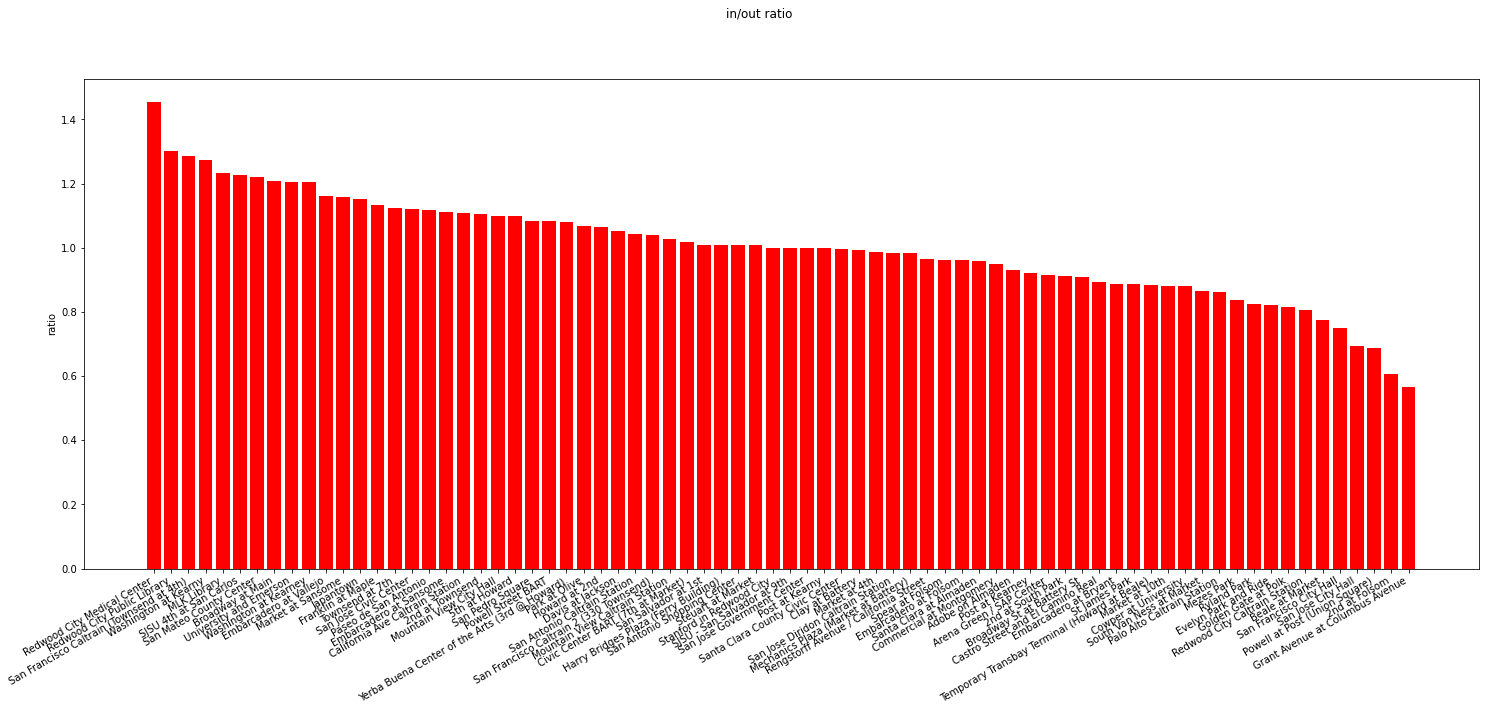

In [25]:
plot_hist(degreeRatio.orderBy("degreeRatio", ascending=False), arg = "degreeRatio", title = "in/out ratio", ylabel = "ratio" )

# 3 Graph Algorithms
---

## 3.1 PageRank!


One of the most interesting algorithm we can apply to graphs is google's page rank and find the most **Connected** station

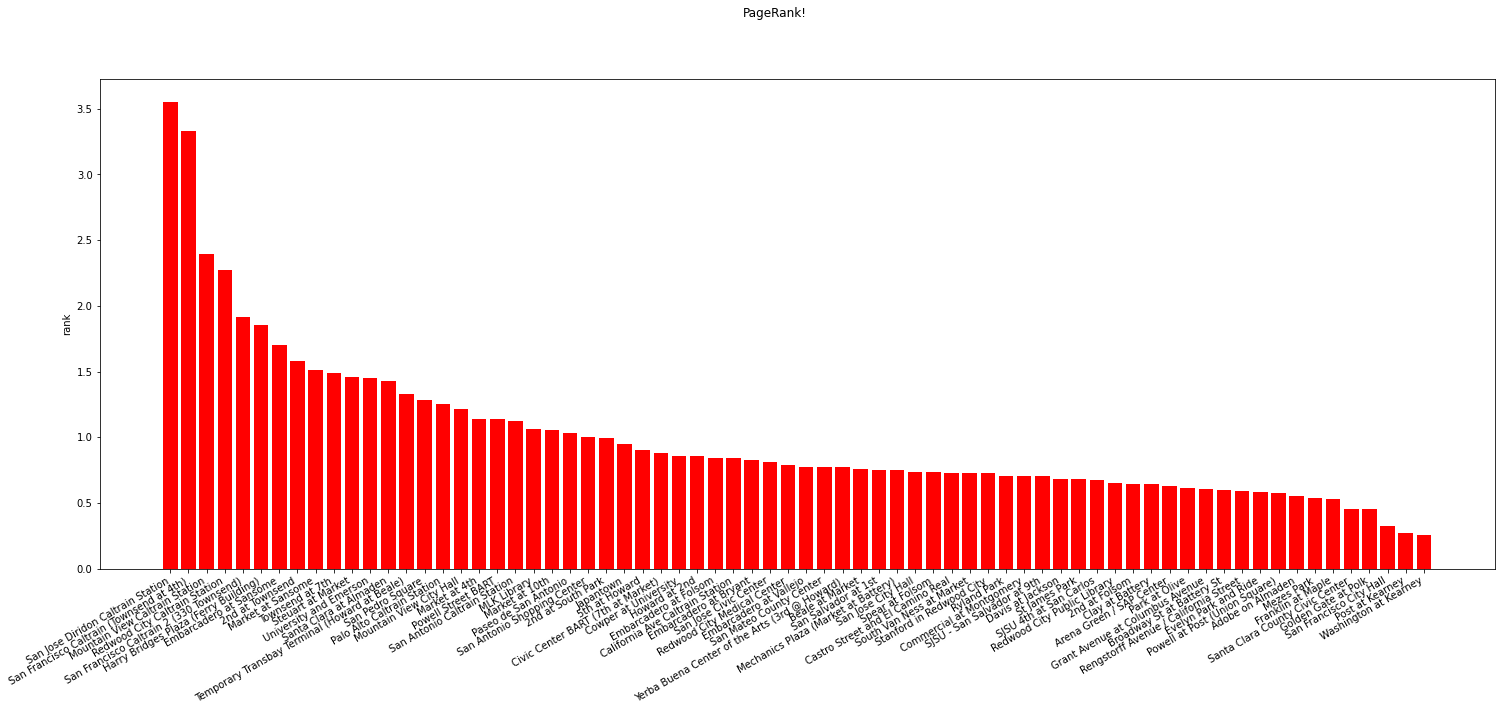

In [26]:
from pyspark.sql.functions import desc
ranks = stationGraph.pageRank(resetProbability=0.15, maxIter=10)
# complete here
result = ranks.vertices.orderBy(desc("pagerank")).select("id", "pagerank")
plot_hist(result, arg = "pagerank", title = "PageRank!", ylabel = "rank" )

## 3.2 BFS search
----

Breadth-first Search will search our graph for how to connect two given nodes based on the edges in the graph. In
our context, we might want to do this to find the shortest paths to different stations. We can specify the maximum of
edges to follow with the `maxPathLength` and we can also specify an `edgeFilter` to filter out certain edges that
do not meet a certain requirement like trips during non-business hours.
We’ll choose two fairly close stations so that this does not run too long. 

However, you can do some pretty interesting
graph traversals when you have some sparse graphs that have some distant connections. Feel free to play around
with the stations (especially those in other cities) to see if you can get some distant stations to connect.

Performing BFS on a trip with max path of 3 :


In [27]:
# try to change maxpathlen
stationGraph.bfs(fromExpr="id = 'Townsend at 7th'",  toExpr="id = 'Spear at Folsom'", maxPathLength=3).show(20)


+--------------------+--------------------+--------------------+
|                from|                  e0|                  to|
+--------------------+--------------------+--------------------+
|[65, Townsend at ...|[7089, 1053, 8/31...|[49, Spear at Fol...|
|[65, Townsend at ...|[7643, 773, 9/1/2...|[49, Spear at Fol...|
|[65, Townsend at ...|[23480, 879, 9/16...|[49, Spear at Fol...|
|[65, Townsend at ...|[26523, 821, 9/18...|[49, Spear at Fol...|
|[65, Townsend at ...|[28316, 812, 9/20...|[49, Spear at Fol...|
|[65, Townsend at ...|[29228, 714, 9/20...|[49, Spear at Fol...|
|[65, Townsend at ...|[31957, 715, 9/23...|[49, Spear at Fol...|
|[65, Townsend at ...|[34200, 615, 9/25...|[49, Spear at Fol...|
|[65, Townsend at ...|[40430, 733, 9/30...|[49, Spear at Fol...|
|[65, Townsend at ...|[49471, 874, 10/7...|[49, Spear at Fol...|
|[65, Townsend at ...|[52074, 776, 10/9...|[49, Spear at Fol...|
|[65, Townsend at ...|[53439, 691, 10/1...|[49, Spear at Fol...|
|[65, Townsend at ...|[54

## 3.3 Strongly Connected Components
---

As our graph is directed we are not intrested in connected components, but we might be intrested in **Strongly connected components**. 

One thing you will likely have to do to run this algorithm on your local is take a sample of the data, just as we do
below. This can help you get to a result without crashing the Spark application with garbage collection issues. We’re
also going to clear the cache in order to ensure there’s enough memory to run for our computation

- A strongly connected component effectively has one way into a subgraph and no way out


In [28]:
# sampling data
#minGraph = GraphFrame(stationVertices, tripEdges.sample(False, 0.2))
scc = stationGraph.stronglyConnectedComponents(maxIter=3)

In [29]:
scc.groupBy("component").count().show()

+---------+-----+
|component|count|
+---------+-----+
|        0|   70|
+---------+-----+



# 3.4 Motif Search

Motifs are a way of expresssing structural patterns in a graph. 

When we specify a motif, we are querying for patterns in the data instead of actual data. 

Our current dataset does not suit this sort of querying because our graph consists of
individual trips, not repeated interactions of certain individuals or identifiers. 

In GraphFrames, we specify our query in a Domain-Specific Language. 

We specify combinations of vertices and edges. 

For example, if we want to specify a given vertex connects to another vertex we would specify `(a)-[ab]->(b)`. 

The letters inside of parenthesis or brackets do not signify values but signify what the columns should be named in the resulting DataFrame. We can omit
the names (e.g.,` (a)-[]->()`) if we do not intend to query the resulting values.

Let’s perform a query. In plain english, let’s find all the round trip rides with two stations in between. We express this
with the following motif using the find method to query our GraphFrame for that pattern. `(a)` signifies the starting
station, `[ab]` represents an edge from `(a)` to our next station `(b)`. We repeat this for stations `(b)` to `(c)` and
then from `(c)` to `(a)`.

In [30]:
motifs = stationGraph.find("(a)-[ab]->(b); (b)-[bc]->(c); (c)-[ca]->(a)")

The resulting DataFrame contains nested fields for vertices a, b, and c as well as the respective edges. 
Now we can query that to answer a specific question. 
Given a certain bike:  

- **What is the shortest round trip time where that bike is taken from one station `(a)`, ridden to another, dropped off
  at `(b)`, ridden to another, dropped off at `(c)`, and then ridden back to the original station, `(a)`** ? 

The following logic will parse our timestamps into Spark timestamps and then we’ll do comparisons to make sure that it’s the same bike,
traveling from station to station, and that the start times for each trip are correct.

In [35]:
from pyspark.sql.functions import expr

res = motifs
res = motifs.where("ca.`bike_id` = bc.`bike_id`")
res = res.where("ab.`bike_id` = bc.`bike_id`")
res = res.where("a.`id` != b.`id`")
res = res.where("b.`id` != c.`id`")
res = res.where("ab.`start_date` < bc.`start_date`")
res = res.where("bc.`start_date` < ca.`start_date`")
#res = res.orderBy(expr("cast(ca.`start_date` as long) - cast(ab.`sart_date` as long)"))

